In [1]:
import sys 
sys.path.append('../scripts/')
from dynamic_programming import *

In [2]:
class BeliefDynamicProgramming(DynamicProgramming):
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, camera, puddle_coef=100.0, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8]): 
        super().__init__(widths, goal, puddles, time_interval, sampling_num, puddle_coef, lowerleft, upperright)
        
 #       self.actions = [(0.0, 2.0), (0.0, -2.0), (1.0, 0.0), (-1.0, 0.0)]  #コメントアウト ###amdp7commentout
  #      self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num)  #コメントアウト
        
        self.index_nums = np.array([*self.index_nums, len(dev_borders) + 1])
        nx, ny, nt, nh = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt), range(nh)))
        
        self.value_function, self.final_state_flags =  self.init_belief_value_function()
        self.policy = np.zeros(np.r_[self.index_nums,2]) 
        
        self.dev_borders = dev_borders
        self.dev_borders_side = [dev_borders[0]/10, *dev_borders, dev_borders[-1]*10]
        self.motion_sigma_transition_probs = self.init_motion_sigma_transition_probs()
        self.obs_sigma_transition_probs = self.init_obs_sigma_transition_probs(camera)
        
        self.depths = self.expected_depths(puddles) #__init__の最後に追加 ###amdp7expecteddepth
        
    def expected_depths(self, puddles, sampling_num=100): #追加
        depths = {}
        for index in itertools.product(range(self.index_nums[0]), range(self.index_nums[1]), range(self.index_nums[3])): #xyσのインデックス
            pose = self.pose_min[0:2] + self.widths[0:2]*(np.array(index[0:2]).T + 0.5) #セルの位置の中心
            sigma = (self.dev_borders_side[index[2]] + self.dev_borders_side[index[2]+1])/2 #σの中心
            belief = multivariate_normal(mean=pose, cov=np.eye(2)*(sigma**2)) #分布を構成（向きの次元は落としているので2次元）
            depth_sum = 0.0
            for pos in belief.rvs(sampling_num): #信念分布から位置をサンプリング
                depth_sum += sum([p.depth*p.inside(pos) for p in puddles])
                
            depths[index] = depth_sum/sampling_num
        return depths

    def init_obs_sigma_transition_probs(self, camera):
        probs = {}
        for index in self.indexes: 
            pose = self.pose_min + self.widths*(np.array(index[0:3]).T + 0.5) 
            sigma = (self.dev_borders_side[index[3]] + self.dev_borders_side[index[3]+1])/2 
            S = (sigma**2)*np.eye(3)

            for d in camera.data(pose):
                S = self.observation_update(d, S, camera, pose)
                    
            probs[index] = {self.cov_to_index(S):1.0}

        return probs
    
    def observation_update(self, d, S, camera, pose):
        distance_dev_rate, direction_dev = 0.14, 0.05
        z = d[0]
        obs_id = d[1]
        H = matH(z, pose, camera.map.landmarks[obs_id].pos)
        estimated_z = IdealCamera.observation_function(pose, camera.map.landmarks[obs_id].pos)
        Q = matQ(distance_dev_rate*estimated_z[0], direction_dev)
        K = S.dot(H.T).dot(np.linalg.inv(Q + H.dot(S).dot(H.T)))
        return (np.eye(3) - K.dot(H)).dot(S)
        
    def init_motion_sigma_transition_probs(self):
        probs = {}
        for a in self.actions:
            for i in range(len(self.dev_borders)+1):
                probs[(i, a)] = self.calc_motion_sigma_transition_probs(self.dev_borders_side[i], self.dev_borders_side[i+1], a)
                
        return probs
            
    def cov_to_index(self, cov):
        sigma = np.power(np.linalg.det(cov), 1.0/6)
        for i, e in enumerate(self.dev_borders):
            if sigma < e: return i
            
        return len(self.dev_borders)
        
    def calc_motion_sigma_transition_probs(self, min_sigma, max_sigma, action, sampling_num=100):
        nu, omega = action
        if abs(omega) < 1e-5: omega = 1e-5

        F = matF(nu, omega, self.time_interval, 0.0) #ロボットの向きは関係ないので0[deg]で固定で
        M = matM(nu, omega, self.time_interval, {"nn":0.19, "no":0.001, "on":0.13, "oo":0.2})#移動の誤差モデル（カルマンフィルタのものをコピペ）
        A = matA(nu, omega, self.time_interval, 0.0)
        
        ans = {}
        for sigma in np.linspace(min_sigma, max_sigma*0.999, sampling_num): #遷移前のσを作る（区間内に一様分布していると仮定）
            index_after = self.cov_to_index(sigma*sigma*F.dot(F.T) + A.dot(M).dot(A.T)) #遷移後のσのインデックス
            ans[index_after] = 1 if index_after not in ans else ans[index_after] + 1 #単にカウントしてるだけ（辞書の初期化もあるのでややこしい）
                
        for e in ans:
            ans[e] /= sampling_num #頻度を確率に

        return ans
    
    def init_belief_value_function(self): 
        v = np.empty(self.index_nums)
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.belief_final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def belief_final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index[0:3] 
        x_max, y_max, _ = self.pose_min + self.widths*(index[0:3] + 1) 
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] 
        return all([self.goal.inside(np.array(c).T) for c in corners ]) and index[3] == 0
    
    def action_value(self, action, index, out_penalty=True):###amdp7actionvalue
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]:
            after, out_reward = self.out_correction(np.array(index[0:3]).T + delta)
        
            for sigma_after, sigma_prob in self.motion_sigma_transition_probs[(index[3], action)].items():
                for sigma_obs, sigma_obs_prob in dp.obs_sigma_transition_probs[(*after, sigma_after)].items():
                    reward = - self.time_interval * self.depths[(after[0], after[1], sigma_obs)] * self.puddle_coef \
                        - self.time_interval + out_reward*out_penalty #ここで報酬を計算。self.depthsのインデックスにsigma_obsを追加。
                    value += (self.value_function[(*after, sigma_obs)] + reward) * prob * sigma_prob * sigma_obs_prob

        return value

In [3]:
puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)]

##地図とカメラを作る##
m = Map()
for ln in [(1,4), (4,1), (-4,-4)]: m.append_landmark(Landmark(*ln)) #位置をQMDPの実験に合わせる
c = IdealCamera(m)
    
dp = BeliefDynamicProgramming(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.1, 10, c) #カメラを加える

In [4]:
def save():
    with open("policy_amdp.txt", "w") as f:  ###amdp6sweeps
        for index in dp.indexes:
            p = dp.policy[index]
            f.write("{} {} {} {} {} {}\n".format(index[0], index[1], index[2],index[3], p[0], p[1])) #一つ{}とindexの要素を増やす

    with open("value_amdp.txt", "w") as f:
        for index in dp.indexes:
            p = dp.value_function[index]
            f.write("{} {} {} {} {}\n".format(index[0], index[1], index[2], index[3], p)) #5行目と同じ

delta = 1e100
counter = 0

while delta > 0.01: 
    delta = dp.value_iteration_sweep()
    counter += 1
    print(counter, delta)
    save()

1 99.8924731167315
2 99.37758757038849
3 47.52732567595228
4 29.28882861827406
5 23.998502262218032
6 19.77685009119614
7 18.05819070842997
8 16.28186629921276
9 15.063210456195222
10 14.228496924496795
11 13.754502281034782
12 12.825229003453039
13 12.332375673886474
14 11.830346910146119
15 10.898075034580373
16 9.439586211213545
17 8.691298225076345
18 8.284169405348607
19 7.921908717138237
20 7.6676642828824555
21 7.372376210998674
22 7.103095315349229
23 6.86236345141436
24 6.776018513387427
25 6.6568041926245485
26 6.582870630411762
27 6.557157285485786
28 6.526647188130781
29 6.293901364969962
30 5.914169611837551
31 5.815209065528876
32 5.611009466728298
33 5.446229876885262
34 5.33914693566966
35 5.238150727514707
36 5.142741469546877
37 5.052487045189466
38 4.966997615857572
39 4.8858829532668935
40 4.756322177715127
41 4.562098439969873
42 4.31441128006184
43 4.025468626861603
44 3.841102979636389
45 3.7065932972207634
46 3.5458634940215745
47 3.3463173386543446
48 3.1122762

<IPython.core.display.Javascript object>


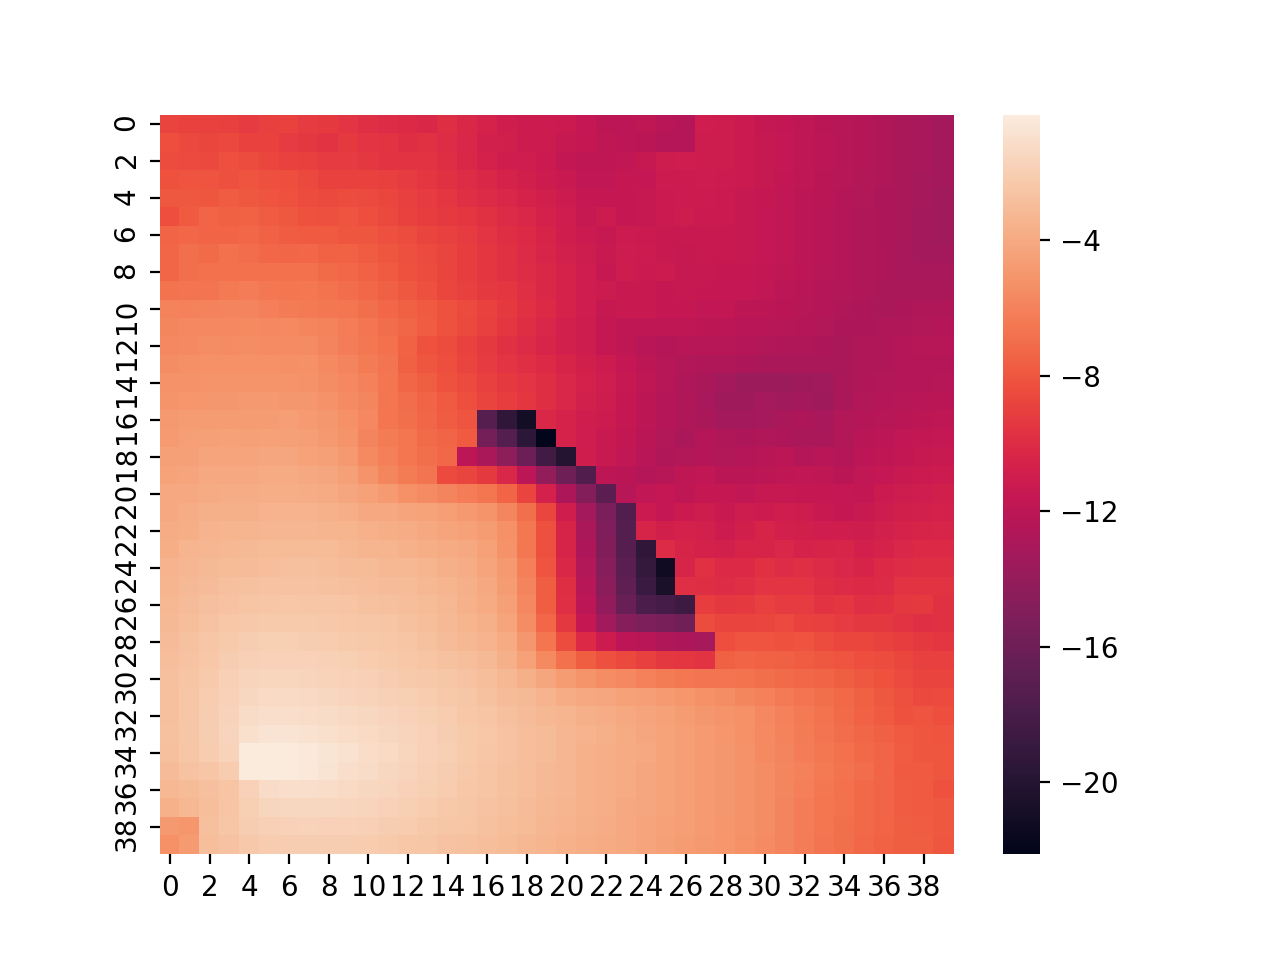

In [10]:
import seaborn as sns
v = dp.value_function[:, :, 18, 4]
sns.heatmap(np.rot90(v), square=False)
plt.show()